# Pose Bowl: Object Detection


<a id="import-libraries"></a>

## 📚 | Import Libraries 

In [306]:
import sys
sys.path.append('/Users/jsh/code/drivendata/spacecrafts/')

In [307]:
from pathlib import Path
import numpy as np
import pandas as pd
import math

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import transforms, v2
from scripts.score import jaccard_index

<a id="configuration"></a>
## ⚙️ | Configuration

In [308]:
PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"

<a id="datasets"></a>
## 🍚 | Datasets

In [309]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")

In [310]:
train_meta.shape, train_labels.shape

((25801, 2), (25801, 4))

In [311]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [312]:
train_meta.head()

,spacecraft_id,background_id
image_id,,
0001954c9f4a58f7ac05358b3cda8d20,24,247
00054819240f9d46378288b215dbcd3a,14,10
000dbf763348037b46558bbcb6a032ac,19,17
000e79208bebd8e84ce6c22fd8612a0d,14,15
000f13aff94499d03e3997afc55b0aa0,28,15


In [313]:
# we didn't download the full training set, so add a column indicating which images are saved locally
train_meta["exists"] = train_meta.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())
train_labels["exists"] = train_labels.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())

# filter our metadata and training data down to only the images we have locally
train_meta = train_meta[train_meta.exists]
train_labels = train_labels[train_labels.exists]

print(train_meta.shape, train_labels.shape)

# Check indexes are the same
if train_meta.index.equals(train_labels.index):
    print("The indexes are the same.")
else:
    print("The indexes are different.")

(1579, 3) (1579, 5)
The indexes are the same.


In [314]:
# Examine an example image
example_img_idx = '000e79208bebd8e84ce6c22fd8612a0d'
example_img_path = Path(IMAGES_DIRECTORY, example_img_idx + '.png')
example_img = Image.open(str(example_img_path))
print('Original image', example_img.format, example_img.size, example_img.mode)

transform = transforms.Compose([
    # transforms.Resize(512),
    transforms.ToTensor(),
])

example_img = transform(example_img)

if example_img.min() >= 0 and example_img.max() <= 1:
    print("Image pixel values are in the range [0, 1].")
else:
    print("Image pixel values are not in the range [0, 1].")

print('Transformed image', example_img.shape)

Original image PNG (1280, 1024) RGB
Image pixel values are in the range [0, 1].
Transformed image torch.Size([3, 1024, 1280])


In [315]:
# Create pytorch DataSet
class SpacecraftDataset(torch.utils.data.Dataset):
    def __init__(self, labels_df, meta_df, imgs_dir=IMAGES_DIRECTORY, transforms=None):
        self.imgs_dir = imgs_dir
        self.labels_df = labels_df # dataframe of indexes and bbox coordinates
        self.meta_df = meta_df
        self.img_idxs = labels_df.index.tolist()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # Get image id and path
        img_id = self.img_idxs[idx]
        img_path = str(Path(self.imgs_dir, img_id + '.png'))
        n_objs = 1
        
        # Load image
        img = Image.open(img_path)

        # Get spacecraft id
        labels = torch.ones(n_objs, dtype=torch.int64)

        # Get bbox coordinates
        bbox = self._get_bbox(img_id)
        
        # Convert data to format needed by model.
        target = {}
        target['boxes'] = torch.from_numpy(bbox).reshape((1,4))
        target['labels'] = labels
        target['image_id'] = img_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.img_idxs)

    def _get_bbox(self, image_id):
        return self.labels_df.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.astype('int')

In [316]:
def collate_fn(batch):
    return list(zip(*batch))

In [317]:
# Create super small train and validation sets for quick iteration
dataset = SpacecraftDataset(train_labels, train_meta, transforms=transform)
train_ds = Subset(dataset, torch.arange(10))
valid_ds = Subset(dataset, torch.arange(10, 20))

train_dl = DataLoader(
    train_ds,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn
)

In [318]:
len(train_ds)

10

## 🩼 | Helper Functions

In [319]:
# For evaluation
def images2tensors(img_ids):
    tensors = []
    for id in img_ids:
        img_path = str(Path(IMAGES_DIRECTORY, id + '.png'))
        img = read_image(img_path) / 255
        tensors.append(img)
    return tensors

In [320]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values

def display_image(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    print(type(img))
    print(img.shape)
    print(np.flip(img, axis=-1).shape)
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

<class 'numpy.ndarray'>
(1024, 1280, 3)
(1024, 1280, 3)


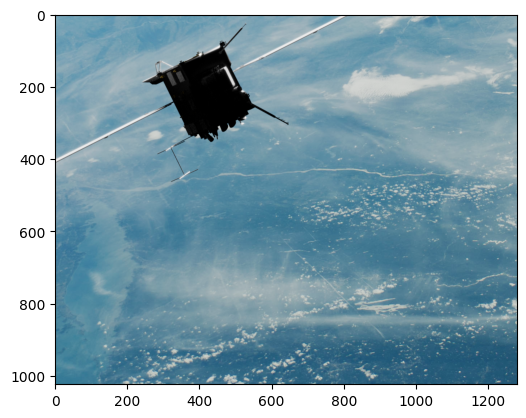

In [321]:
display_image('04e3b4e7bc79869d8eefc59f55914b6a')

<a id="model"></a>
## 🤖 | Model

In [322]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", trainable_backbone_layers=0)
# Adjust the model for spacecraft recognition task.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2 # 2 classes are spacecraft or background
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [323]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [346]:
# Test a forward pass
dataset = SpacecraftDataset(train_labels, train_meta, transforms=transform)
data_loader = DataLoader(
    dataset,
    batch_size=5,
    shuffle=True,
    collate_fn=collate_fn
)


In [347]:

# For training
images, targets = next(iter(data_loader))
images = list(images)
targets = list(targets)
output = model(images, targets)
print(output)

[{'boxes': tensor([[ 798.3589,  889.4011,  913.0121,  957.5433],
        [ 798.2891,  899.2029,  850.0651,  930.0408],
        [ 785.9816,  874.4794,  901.6053,  925.3072],
        [ 817.0687,  895.1756,  842.5311,  928.8044],
        [ 810.7305,  891.9988,  849.1535,  920.3734],
        [ 823.3365,  885.1147,  842.8071,  904.6914],
        [  70.0010,  118.9713, 1218.9043,  412.4821],
        [  81.2958,  244.6242, 1202.9059,  576.2671],
        [ 790.6876,  886.9459,  851.4253,  943.5361],
        [ 811.7146,  634.4972,  984.1982,  671.9412],
        [ 773.8982,  866.7104,  935.9727,  963.2598],
        [ 514.8087,  913.5082,  998.6497,  989.1133],
        [ 791.4559,  908.1398,  848.5152,  955.9539],
        [ 828.5332,  879.2108, 1192.2109,  952.9138],
        [  62.4086,    6.0578, 1072.7039,  115.8770],
        [  98.2588,  416.5663, 1219.0745,  714.3123],
        [ 803.6235,  903.0825,  859.8552,  946.3736],
        [ 701.8685,  870.3935,  838.6482,  932.6882],
        [ 102.270

In [348]:
# For inference
images, targets = next(iter(data_loader))
images = list(images)
model.eval()
predictions = model(images)
print(predictions)

[{'boxes': tensor([[  72.1604,   88.1835, 1243.0820,  632.0101],
        [1038.5031,  735.5957, 1121.9835,  798.3019],
        [ 715.7316,  862.9703, 1273.7216, 1006.4318],
        [1055.0311,  706.2913, 1159.4807,  793.3129],
        [1061.0920,  741.3633, 1105.5165,  787.9960],
        [ 764.1621,  954.6293, 1262.7385, 1012.4326],
        [ 730.9299,  916.8486, 1154.4570, 1013.5092],
        [  86.7299,  318.8101, 1182.8604,  878.3617],
        [  70.6944,  564.5370, 1238.2395, 1013.4008],
        [  69.6844,  321.2503,  819.0217,  731.5189],
        [ 100.8745,   24.3681, 1194.1285,  316.7517],
        [  61.9601,  147.6595,  815.1825,  569.8592],
        [  52.1204,  121.0001,  225.7919,  760.0378],
        [1044.5502,  722.7945, 1162.8015,  847.7010],
        [ 157.9916,  780.2726, 1224.9315, 1024.0000],
        [  62.8002,    8.9404,  995.3043,  135.5057],
        [ 546.6876,  737.7692, 1079.8496,  995.6067],
        [1103.0137,  699.4583, 1270.2009,  798.5406],
        [  45.543

<a id="loss-and-optimizer"></a>
## 🔍 | Loss & Optimizer

In [349]:
images[0].shape

torch.Size([3, 1024, 1280])

In [350]:
targets

({'boxes': tensor([[1049,  699, 1153,  778]]),
  'labels': tensor([1]),
  'image_id': '0f7aa4f498d245a87bbca696cf119b59'},
 {'boxes': tensor([[ 285,    0, 1280, 1024]]),
  'labels': tensor([1]),
  'image_id': '008c5f9df5b23b5a99b5a9f68d63ad55'},
 {'boxes': tensor([[   0,  576,  323, 1024]]),
  'labels': tensor([1]),
  'image_id': '0b656185aa22f8be53d73f74c8ca24c7'},
 {'boxes': tensor([[ 240,  707,  884, 1024]]),
  'labels': tensor([1]),
  'image_id': '0bab7ff5501482c866c97109329d7d96'},
 {'boxes': tensor([[ 318,  324, 1022,  992]]),
  'labels': tensor([1]),
  'image_id': '0d6ad15f117fc34832a92d5e14a47f53'})

In [351]:
len(targets)

5

In [352]:
target_bboxes = []
for target in targets:
    target_bboxes.append(target['boxes'])
torch.stack(target_bboxes).shape


torch.Size([5, 1, 4])

In [353]:
target_bs = torch.stack([target['boxes'] for target in targets]).squeeze().numpy()
target_bs.shape

(5, 4)

In [391]:
predictions[0]['boxes'][0]

tensor([  72.1604,   88.1835, 1243.0820,  632.0101], grad_fn=<SelectBackward0>)

In [355]:
get_target_bboxes(targets).squeeze().shape

(5, 4)

In [356]:
predicted_bs = torch.stack([pred['boxes'][0] for pred in predictions]).detach().numpy()
predicted_bs

array([[  72.16039 ,   88.183495, 1243.082   ,  632.01013 ],
       [  47.85863 ,   88.390816,  329.01495 ,  480.59082 ],
       [  55.377518,  580.9714  ,  223.68564 ,  717.68933 ],
       [ 402.04974 ,  499.19986 ,  543.37585 ,  539.4416  ],
       [  74.2591  ,  570.43744 ,  876.0689  ,  813.24896 ]],
      dtype=float32)

In [357]:
jaccard_index(predicted=predicted_bs, actual=target_bs)

array([0.        , 0.01552556, 0.15901939, 0.        , 0.255934  ])

In [358]:
params = [p for p in model.parameters() ]
len(params)

83

In [359]:
# Define loss and optimizer
def get_predicted_bboxes(preds):
    return torch.stack([pred['boxes'][0] for pred in preds if len(pred['boxes']) > 0 else ]).detach().numpy()

def get_target_bboxes(targets):
    return torch.stack([target['boxes'] for target in targets]).numpy().squeeze()

def loss_fn(preds, targets):
    criterion = nn.SmoothL1Loss(reduction='mean')
    predicted_bboxes = get_predicted_bboxes(preds)
    target_bboxes = get_target_bboxes(targets)
    return criterion(predicted_bboxes, target_bboxes)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.001)

<a id="training"></a>
## 🚂 | Training

In [360]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [36]:
def train_one_epoch(model, optimizer, data_loader, device, epoch,):
    model.train()
    header = f"Epoch: [{epoch}]"
    print(header + ' initiated:')

    for idx, data in enumerate(data_loader):
        print(f'  processing batch {idx}')
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        with torch.device(device=device):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        if not math.isfinite(loss):
            print(f"Loss is {loss}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(header + f" loss: {loss}")
    print('Model loss dict:', loss_dict, '\n')

In [32]:
model.to('cpu')
n_epochs = 2
for epoch in range(n_epochs):
    train_one_epoch(model, optimizer, data_loader=train_dl, device='cpu', epoch=epoch)

Epoch: [0] initiated:
  processing batch 0
Epoch: [0] loss: 17.15031623840332
Model loss dict: {'loss_classifier': tensor(0.6443, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0233, grad_fn=<DivBackward0>), 'loss_objectness': tensor(4.5986, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(11.8841, grad_fn=<DivBackward0>)} 

Epoch: [1] initiated:
  processing batch 0
Epoch: [1] loss: 13.838117599487305
Model loss dict: {'loss_classifier': tensor(0.0538, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0119, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.6054, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(12.1670, grad_fn=<DivBackward0>)} 



In [341]:
def evaluate(model, data_loader):
    model.eval()
    for idx, data in enumerate(data_loader):
        images, targets = data
        images = list(images)
        preds = model(images)
        predicted_bboxes = get_predicted_bboxes(preds)
        target_bboxes = get_target_bboxes(targets)
        jac = jaccard_index(predicted_bboxes, target_bboxes)
    print('Jaccard Index on validation set: ', jac)
    return jac

In [85]:
evaluate(model, valid_dl)

Jaccard Index on validation set:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
n_epochs = 2
# Define function to train the model
def train(model, n_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * n_epochs
    jac_hist_train = [0] * n_epochs
    loss_hist_valid = [0] * n_epochs
    jac_hist_valid = [0] * n_epochs
    # model.to(device)
    for epoch in range(n_epochs):

        model.train() # Sets mode for dropout layer
        for images, targets in train_dl:
            # images = images.to(device)
            # targets = targets.to(device)
            # with torch.device(device):
            preds = model(images, targets) # !!!! The output on training is not a single preds object. NEED TO CHANGE.
            print(preds)
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            predicted_bboxes = get_predicted_bboxes(preds).detach().numpy()
            target_bboxes = get_predicted_bboxes(targets).numpy()
            loss_hist_train[epoch] += loss.item()*len(targets)
            jac_hist_train += jaccard_index(predicted_bboxes, target_bboxes)
        loss_hist_train[epoch] /= len(train_dl.dataset)
        jac_hist_train[epoch]  /= len(train_dl.dataset)

        model.eval() # Sets mode for dropout layer
        with torch.no_grad():
            for images, targets in valid_dl:
            #         images = images.to(device)
            #         targets = targets.to(device)
            #         with torch.device(device):
                preds = model(images, targets)
                loss = loss_fn(preds, targets)
                predicted_bboxes = get_predicted_bboxes(preds)
                target_bboxes = get_predicted_bboxes(targets)
                loss_hist_valid[epoch] += loss.item()*len(targets)
                jac_hist_valid += jaccard_index(predicted_bboxes, target_bboxes)
            loss_hist_train[epoch] /= len(valid_dl.dataset)
            jac_hist_train[epoch]  /= len(valid_dl.dataset)

        print(f'Epoch {epoch + 1} accuracy: '
              f'{jac_hist_train[epoch]:.4f} val_accuary '
              f'{jac_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid, jac_hist_train, jac_hist_valid          
        

In [57]:
train(model, n_epochs, train_dl, valid_dl)

{'loss_classifier': tensor(0.5385, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1653, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0090, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, grad_fn=<DivBackward0>)}


TypeError: string indices must be integers

## 📋 | Result

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
# optionally, if you want to export the model to ONNX:
torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

The `train_labels.csv` contains the bounding box information for the target spacecraft in each image.

In [293]:
len(targets)

3

In [363]:
def display_images(images, targets, preds, cols=2):
    rows = (len(images) + cols - 1) // 2
    fig = plt.figure(figsize=(15, 5*rows))
    target_bboxes = get_target_bboxes(targets)
    predicted_bboxes = get_predicted_bboxes(preds)
    for idx, target in enumerate(targets):
        img_idx = target['image_id']
        target_bbox = target_bboxes[idx]
        pred_bbox = predicted_bboxes[idx]
        img = images[idx]
        ax = fig.add_subplot(rows, cols, idx + 1)
        show_image(img_idx, img, pred_bbox, target_bbox, ax)

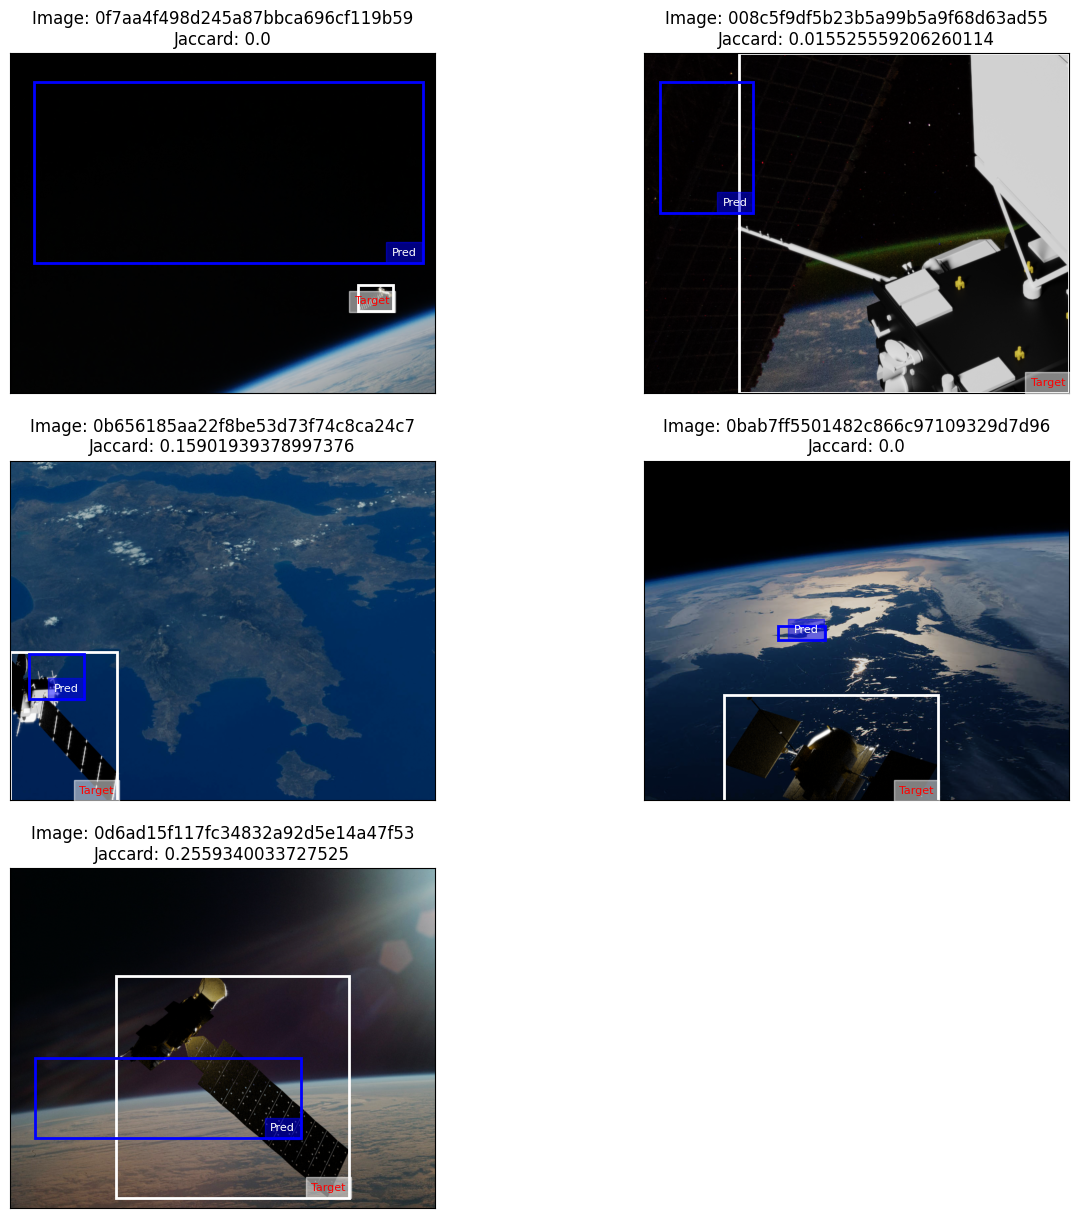

In [387]:
display_images(images, targets, predictions, cols=2)

In [382]:
def show_image(img_idx=None, img=None, pred_bbox=None, target_bbox=None, ax=None):
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)

    if target_bbox is not None:
        xmin, ymin, xmax, ymax = target_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(patch)
        ax.text(xmin + width - 63, ymin + height - 30, 'Target', color='r', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(patch)
        ax.text(xmin + width - 55, ymin + height - 30, 'Pred', color='white', ha='center', va='center', fontsize=8, bbox=dict(facecolor='blue', edgecolor='blue', alpha=0.5))
    
    if (pred_bbox is not None) and (target_bbox is not None):
       jac = jaccard_index(pred_bbox.reshape(1,4), target_bbox.reshape(1,4))
    else:
       jac = 'n/a' 

    title = f'Image: {img_idx}\nJaccard: {jac[0]}'
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [383]:
targets[1]['image_id']

'008c5f9df5b23b5a99b5a9f68d63ad55'

In [384]:
target_bbox = get_target_bboxes(targets)[1]
target_bbox

array([ 285,    0, 1280, 1024])

In [385]:
pred_bbox = get_predicted_bboxes(predictions)[1]
pred_bbox

array([ 47.85863 ,  88.390816, 329.01495 , 480.59082 ], dtype=float32)

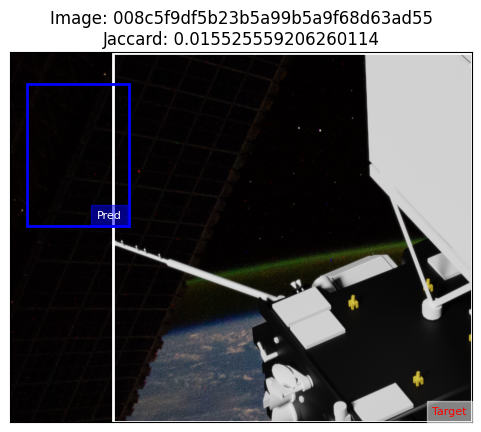

In [386]:
fig, ax = plt.subplots()
show_image(img_idx=targets[1]['image_id'], img=images[1].numpy(), target_bbox=target_bbox, pred_bbox=pred_bbox, ax=ax)

In [ ]:
images[0]

tensor([[[0.4510, 0.4549, 0.4510,  ..., 0.5922, 0.5922, 0.5922],
         [0.4510, 0.4471, 0.4549,  ..., 0.5843, 0.5922, 0.5882],
         [0.4510, 0.4471, 0.4588,  ..., 0.5765, 0.5765, 0.5765],
         ...,
         [0.2118, 0.2078, 0.2000,  ..., 0.1373, 0.1412, 0.1333],
         [0.2118, 0.2118, 0.1961,  ..., 0.1451, 0.1412, 0.1451],
         [0.2078, 0.2118, 0.2078,  ..., 0.1451, 0.1451, 0.1490]],

        [[0.6392, 0.6431, 0.6392,  ..., 0.6863, 0.6902, 0.6902],
         [0.6392, 0.6392, 0.6431,  ..., 0.6824, 0.6902, 0.6863],
         [0.6392, 0.6353, 0.6431,  ..., 0.6824, 0.6824, 0.6863],
         ...,
         [0.4745, 0.4745, 0.4863,  ..., 0.3373, 0.3412, 0.3333],
         [0.4745, 0.4784, 0.4824,  ..., 0.3451, 0.3412, 0.3451],
         [0.4706, 0.4745, 0.4824,  ..., 0.3451, 0.3451, 0.3490]],

        [[0.7176, 0.7216, 0.7176,  ..., 0.7216, 0.7255, 0.7255],
         [0.7176, 0.7137, 0.7216,  ..., 0.7176, 0.7216, 0.7216],
         [0.7176, 0.7137, 0.7216,  ..., 0.7176, 0.7176, 0.

In [6]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


Let's look at a few example images to get a feel for what's in this dataset.

### Review the benchmark submission scripts

Now let's take a look at the 2 files in `/example_benchmark`. This is the directory we are going to convert into a `submission.zip` file, which you can submit for the challenge.
* The `main.sh` shell script is a _required_ file for any submission to this challenge. Our code execution platform will run this script, and you can have it call other scripts and resources as needed for your submission.
* The `main.py` Python script is called by `main.sh` in this benchmark example, and this is where the work of generating predictions actually happens. There is no requirement that you also use Python here, but that's the approach we've taken since it is such a common one. The `main.py` script will iterate through all the images in the `submission_format.csv` and generate predictions using YOLO. If YOLO doesn't return a prediction, we simply generate a bounding box for the center of the image.

The `example_benchmark` directory should now contain the following files.  Note that we do need to include the `yolov8n.pt` file because the submission will have no internet access when running on our platform.
```
spacecraft-pose-object-detection-runtime/
└── example_benchmark/
    ├── main.py
    ├── main.sh
    └── yolov8n.pt
```

### Three commands to prepare your submission
To run and test the benchmark example, you just need to execute the following 3 commands:

1. [`make pull`](#make-pull)
2. [`make pack-benchmark`](#make-pack-benchmark)
3. [`make test-submission`](#make-test-submission)

These are defined in the project `Makefile` [here](https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime/blob/main/Makefile). We'll walk through what each one does now.

<a id="make-pull"></a>

#### **`make pull`**

To ensure that all participants are using the same runtime environment, we have a publicly accessible docker image hosted on [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/).

The `make pull` command pulls the official version of the docker image and stores it locally. Having a local version of the competition image allows you to test your submission using the same image that is used during code execution.

> **Note:** This command can take a little while to run the first time you pull the image. But after that it will be relatively quick since you'll have all the layers cached locally. You don't need to pull the image again each time you test your submission, unless the image has changed.

In [17]:
!cd {PROJ_DIRECTORY} && make pull

docker pull spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest
latest: Pulling from spacecraft-pose-object-detection
Digest: sha256:025731e47e851c8f57363fc4d5a2e3fd44ec1a64f2089ba9d728ad7c8057f3a7
Status: Image is up to date for spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest
spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest


You should now have a local copy of the docker image, which you can verify by running:

In [27]:
!docker images | grep spacecraft-pose-object-detection

spacecraftpose.azurecr.io/spacecraft-pose-object-detection   latest    bc1d6eb59ba6   4 days ago     5.74GB


<a id="make-pack-benchmark"></a>

#### **`make pack-benchmark`** 
This command simply goes to your `example_benchmark` directory, zips the contents, and writes the zip archive to `submission/submission.zip`.

In [28]:
!cd {PROJ_DIRECTORY} && make pack-benchmark

mkdir -p submission/
cd example_benchmark; zip -r ../submission/submission.zip ./*
  adding: main.py (deflated 61%)
  adding: main.sh (deflated 26%)
  adding: yolov8n.pt (deflated 9%)


> **Note:** The `make pack-benchmark` command will check to see if you already have a `submission/submission.zip` and error if you do, so as not to overwrite existing work. If you already have this file, you'll need to manually remove it before running the command.

After running the above command, we should now have a new **`submission/submission.zip`**.
```
spacecraft-pose-object-detection-runtime/
├── benchmark_src/
│   ├── main.py
│   ├── main.sh
│   └── yolov8n.pt
└── submission/
    └── submission.zip   <---- new file, this is what gets submitted on platform
```

This is the file that we will eventually upload to the competition platform for code execution. But before doing that, we want to test it locally.

<a id="make-test-submission"></a>

#### **`make test-submission`** 
This command simulates what happens during actual code execution, launching an instance of the official Docker image and running the same inference process that runs on the competition platform. The required host directories are mounted on the container, and the entrypoint script `main.sh` is executed. Note that when testing locally the contents of your local `data/` directory will be mounted on the container, whereas when your submission is running on our platform, the unseen test set will be mounted as `data/`.

In [29]:
!cd {PROJ_DIRECTORY} && make test-submission

mkdir -p submission/
chmod -R 0777 submission/
docker run \
		-it \
		--network none \
		--mount type=bind,source="/Users/jsh/code/drivendata/spacecraft-pose-object-detection-runtime"/data,target=/code_execution/data,readonly \
		--mount type=bind,source="/Users/jsh/code/drivendata/spacecraft-pose-object-detection-runtime"/submission,target=/code_execution/submission \
		--shm-size 8g \
		--name spacecraft-pose-object-detection \
		--rm \
		bc1d6eb59ba6
+ main
+ tee /code_execution/submission/log.txt
+ cd /code_execution
+ curl --silent --connect-timeout 10 --max-time 12 www.example.com
+ data_directory=/code_execution/data
+ format_filename=/code_execution/data/submission_format.csv
+ (( i=0 ))
+ (( i<=5 ))
+ t=0
+ '[' -f /code_execution/data/submission_format.csv ']'
+ echo 'found /code_execution/data/submission_format.csv after 0 seconds; data is mounted'
found /code_execution/data/submission_format.csv after 0 seconds; data is mounted
+ break
+ '[' '!' -f /code_execution/data/submi

Once the test run has completed, we should now have a new file with our predictions at **`submission/submission.csv`**.
```
spacecraft-pose-object-detection-runtime/
├── benchmark_src/
│   ├── main.py
│   ├── main.sh
│   └── yolov8n.pt
└── submission/
    ├── submission.zip   <---- this is what gets submitted on platform
    └── submission.csv   <---- new file, predictions on test set
```
We also provide a scoring script that computes your score using the same calculation that's used for the public leaderboard. You can generate a score for your local testing with a command like the one below. Remember that this score will be computed on your local test set, and your score on the public leaderboard will be based on an unseen test set.
```
python scripts/score.py submission/submission.csv data/test_labels.csv
```

### Submitting to the platform
We're almost done. Assuming that our test run completed and the `submission.csv` looks correct, it's time to submit the code on the platform.

* Go to the [competition submissions page](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) and upload your `submission/submission.zip`.
* Please be patient while your submission is uploaded and executed. Your job may be queued if other jobs are still pending.
* You can track the status of your submission on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page. Logs will become available once the submission begins processing. To see them click on "View Log".

Once your submission has been successfully uploaded, you will see something like this on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page:

![code execution status](https://drivendata-public-assets.s3.amazonaws.com/spacecraft-benchmark-code-status.jpg)

Please be patient while your code is running. You may want to follow the links to check the logs for your job, which are live updated as your code job progresses.

Once your job has completed, head over to the [Submissions](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) page where you should be able to see your score. It will look something like this, except that we're sure you can do better than the benchmark!

![score](https://drivendata-public-assets.s3.amazonaws.com/spacecraft-benchmark-score.jpg)

**That's it! You're on your way to creating your own code submission!**

**Head over to the [competition](https://www.drivendata.org/competitions/260/spacecraft-detection/) homepage to get started. And have fun! We can't wait to see what you build!**

_Images courtesy of NASA._